PU comparison

In [2]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os, yaml
sys.path.append('../lib')
sys.path.append('../analysis')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar
from array import array
from categoriesDef import categories

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Events
from DataFormats.FWLite import Handle

In [4]:
from prettytable import PrettyTable

In [5]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [6]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [7]:
colors = [rt.kBlack, rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]

In [8]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [9]:
def extractEff(fn):
    with open(fn) as f:
        for l in f.readlines():
            if not l.startswith('Eff'): continue
            return [float(l.split(' ')[1]), float(l.split(' ')[3])]
    return [None, None]

In [10]:
def extractNacc(fn):
    with open(fn) as f:
        for l in f.readlines():
            if not l.startswith('N_accepted'): continue
            return int(l.split(' ')[1])
    return None

# B2DstMu

## Data

In [15]:
loc = '../data/cmsRD/ParkingBPH{}/Run2018D-05May2019promptD-v1_RDntuplizer_PrescaleVertices_200417_CAND.root'
hlistLow = []
hlistMid = []
hlistHigh = []
fAux = []

for i in range(1, 6):
    fAux.append(rt.TFile.Open(loc.format(i), 'READ'))
    hlistLow.append(fAux[-1].Get('nVtx/hNvtxMu7_IP4').Clone())
    hlistMid.append(fAux[-1].Get('nVtx/hNvtxMu9_IP6').Clone())
    hlistHigh.append(fAux[-1].Get('nVtx/hNvtxMu12_IP6').Clone())
    
    print 'Event fraction low: {:.3f} +/ {:.3f}'.format(*getEff(hlistLow[-1].GetEntries(), hlistHigh[-1].GetEntries()))

Event fraction low: 0.489 +/ 0.000
Event fraction low: 0.492 +/ 0.000
Event fraction low: 0.484 +/ 0.000
Event fraction low: 0.492 +/ 0.000
Event fraction low: 0.491 +/ 0.000


In [16]:
loc = '../data/cmsRD/ParkingBPH{}/Run2018C-05May2019-v1_RDntuplizer_PrescaleVertices_200417_CAND.root'
hlistLowC = []
# hlistMid = []
hlistHighC = []
fAuxC = []

for i in range(1, 6):
    fAuxC.append(rt.TFile.Open(loc.format(i), 'READ'))
    hlistLowC.append(fAuxC[-1].Get('nVtx/hNvtxMu7_IP4').Clone())
#     hlistMid.append(fAux[-1].Get('nVtx/hNvtxMu9_IP6').Clone())
    hlistHighC.append(fAuxC[-1].Get('nVtx/hNvtxMu12_IP6').Clone())
    
    print 'Event fraction low: {:.3f} +/ {:.3f}'.format(*getEff(hlistLowC[-1].GetEntries(), hlistHighC[-1].GetEntries()))

Event fraction low: 0.087 +/ 0.000
Event fraction low: 0.087 +/ 0.000
Event fraction low: 0.086 +/ 0.000
Event fraction low: 0.087 +/ 0.000
Event fraction low: 0.086 +/ 0.000


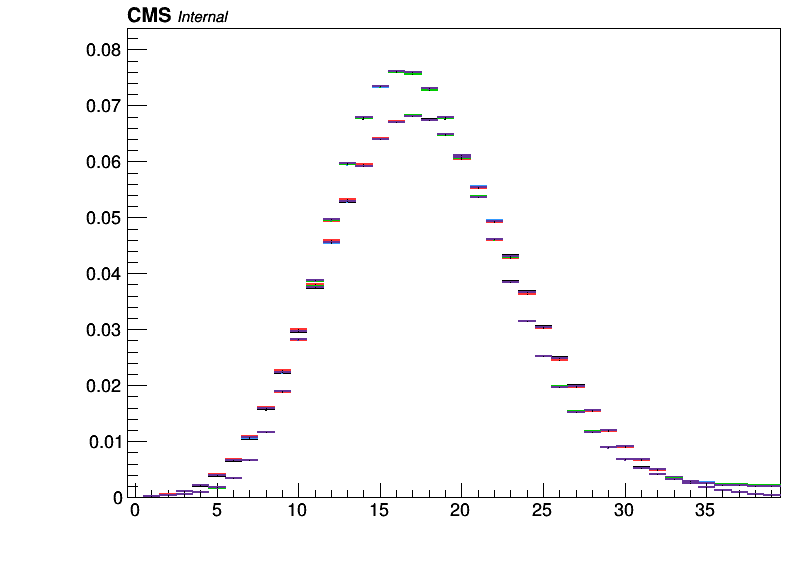

In [18]:
for i in range(0, 5):
    hlistLow[i].SetLineColor(colors[i])
    hlistLow[i].SetLineWidth(2)
    hlistLow[i].Scale(1./hlistLow[i].Integral())
    hlistLow[i].GetXaxis().SetRange(1, 40)
    
for i in range(0, 5):
    hlistLowC[i].SetLineColor(colors[i])
    hlistLowC[i].SetLineWidth(2)
    hlistLowC[i].Scale(1./hlistLowC[i].Integral())
    hlistLowC[i].GetXaxis().SetRange(1, 40)
    
m = SetMaxToMaxHist(hlistLow+hlistLowC)
c = drawOnCMSCanvas(CMS_lumi, hlistLow+hlistLowC, 'same')

In [ ]:
RDloc = '../data/cmsRD/skimmed/B2DstMu_200410_{}_corr.root'
lumiFiles = glob('../data/cmsRD/lumiReport/ParkingBPH*_Run2018*_B2DstMu_200410_brilcalcPerTrigger.yaml')

# Get the lumi
lumis = []
for ic, cat in enumerate(['low', 'mid', 'high']):
    trg = categories[cat].trg
    k = categories[cat].name
    lumiInt = 0
    for fn in lumiFiles:
        d = yaml.load(open(fn, 'r'))
        for n, v in d.iteritems():
            if trg in n:
                lumiInt += v
    lumis.append('{:.1f} fb^{{-1}} ({})'.format(lumiInt, k))
CMS_lumi.integrated_lumi_string = ' + '.join(lumis)
                

# Fill the histo
leg = rt.TLegend(0.7, 0.7, 0.95, 0.9)
leg.SetBorderSize(0)
leg.SetTextFont(42)

hlist = []
stack = False
for ic, cat in enumerate(['Low', 'Mid', 'High']):
    t = ur.open(RDloc.format(cat))['Tevts']
    x = np.array(t.array('N_vtx'))
    h = create_TH1D(x, binning=[61, -0.5, 60.5], axis_title=['Number of PV reco', 'Events'])
    leg.AddEntry(h, cat, 'f')
    if stack:
        h.SetFillColor(colors[ic])
        h.SetFillStyle(3001)
        h.SetLineWidth(0)
        if ic > 0:
            h.Add(hlist[0])
    else:
        h.SetLineColor(colors[ic])
    hlist = [h] + hlist

c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')
leg.Draw()
hRD_PU_catList = hlist

## MC comparison

In [ ]:
CMS_lumi.integrated_lumi_string = ''

In [ ]:
PU_list = ['0', '20', '35', 'c0']
MCsample = {}
dSetSall = {}
dSetS17 = {'Low':{}, 'Mid':{}, 'High':{}}
for n in PU_list:
    print n
    MCsample[n] = DSetLoader('B0_MuNuDmst_PU'+n)
    dSetSall[n] = rtnp.root2array(MCsample[n].skimmed_dir + '/None_skipall_corr.root')
    for cat in dSetS17.keys():
        dSetS17[cat][n] =  rtnp.root2array(MCsample[n].skimmed_dir + '/{}_skip17_corr.root'.format(cat))

### Bare spectrum comparison

In [ ]:
leg = rt.TLegend(0.7, 0.7, 0.95, 0.9)
leg.SetBorderSize(0)
leg.SetTextFont(42)
hlist = [hRD_PU_catList[2].Clone()]
hlist[0].SetLineColor(1)
hlist[0].Scale(1./hlist[0].Integral())
leg.AddEntry(hlist[0], 'Data Low', 'lep')

for i, (n, ds) in enumerate(dSetSall.iteritems()):
    h = create_TH1D(ds['N_vtx'], binning=[61, -0.5, 60.5], 
                    axis_title=['Number of PV reco', 'Events'], 
                    scale_histo='norm')
    leg.AddEntry(h, n, 'lep')
    h.SetLineColor(colors[i+1])
    hlist.append(h)

m = SetMaxToMaxHist(hlist)
c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')
hlist[0].GetYaxis().SetRangeUser(1e-5, m)
leg.Draw()
c.SetLogy()

In [ ]:
cat = 'Low'
plt.figure(figsize=(18,7))
for n in ['0', '20', '35', 'c0']:
    ds = dSetS17[cat][n]
#     ds = dSetSall[n]
    fAux = rt.TFile.Open(MCsample[n].skimmed_dir + '/None_skipall_corr.root', 'READ')
    hMINI = fAux.Get('hAllNvtx')
    hMINI.Scale(1./hMINI.Integral())
    
    hS17 = create_TH1D(ds['N_vtx'], 'hS17', h2clone=hMINI, scale_histo='norm')

    sel = ds['N_goodAddTks'] == 0
    hSig = create_TH1D(ds['N_vtx'][sel], 'hSig', h2clone=hMINI, scale_histo='norm')

    sel = ds['N_goodAddTks'] == 1
    hSide = create_TH1D(ds['N_vtx'][sel], 'hSide', h2clone=hMINI, scale_histo='norm')

    x = []
    rSig = []
    rSide = []
    rS17 = []
    for i in range(1, hMINI.GetNbinsX()+1):
        x.append(hMINI.GetBinCenter(i))
        y = hMINI.GetBinContent(i)
        yerr = hMINI.GetBinError(i)

        if y == 0:
            rSig.append([0,0])
            rSide.append([0,0])
            rS17.append([0,0])
        else:
            ySig = hSig.GetBinContent(i)
            ySigerr = hSig.GetBinError(i)
            if ySig == 0:
                rErr = 0
            else:
                rErr = ySig/y*np.hypot(yerr/y, ySigerr/ySig)
            rSig.append([ySig/y, rErr])

            ySide = hSide.GetBinContent(i)
            ySideerr = hSide.GetBinError(i)
            if ySide == 0:
                rErr = 0
            else:
                rErr = ySide/y*np.hypot(yerr/y, ySideerr/ySide)
            rSide.append([ySide/y, rErr])
            
            yS17 = hS17.GetBinContent(i)
            yS17err = hS17.GetBinError(i)
            if yS17 == 0:
                rErr = 0
            else:
                rErr = yS17/y*np.hypot(yerr/y, yS17err/yS17)
            rS17.append([yS17/y, rErr])

    rSig = np.array(rSig)
    rSide = np.array(rSide)
    rS17 = np.array(rS17)
    
    plt.subplot(1,3,1)
    plt.errorbar(x, rSig[:,0], yerr=rSig[:,1], fmt='.', label=n)
    
    plt.subplot(1,3,2)
    plt.errorbar(x, rSide[:,0], yerr=rSide[:,1], fmt='.', label=n)
    
    plt.subplot(1,3,3)
    plt.errorbar(x, rS17[:,0], yerr=rS17[:,1], fmt='.', label=n)

plt.subplot(1,3,3)
plt.ylim(0.3, 1.5)
plt.title('Skip  additional tracks cut')
plt.subplot(1,3,2)
plt.ylim(0.3, 1.5)
plt.title('N_goodAddTks == 1')
plt.subplot(1,3,1)
plt.ylim(0.3, 1.5)
plt.title('N_goodAddTks == 0')
plt.legend(loc='best');

### Compare xsec and MC efficiency

In [ ]:
#c0 -> 20
fc0 = rt.TFile.Open(MCsample['c0'].skimmed_dir + '/None_skipall_corr.root', 'READ')
hMINI_c0 = fc0.Get('hAllNvtx').Clone()
hMINI_c0.Scale(1./hMINI_c0.Integral())
hMINI_c0.SetLineColor(colors[0])

f20 = rt.TFile.Open(MCsample['20'].skimmed_dir + '/None_skipall_corr.root', 'READ')
hMINI_20 = f20.Get('hAllNvtx').Clone()
hMINI_20.Scale(1./hMINI_20.Integral())
hMINI_20.SetLineColor(colors[1])

f35 = rt.TFile.Open(MCsample['35'].skimmed_dir + '/None_skipall_corr.root', 'READ')
hMINI_35 = f35.Get('hAllNvtx').Clone()
hMINI_35.Scale(1./hMINI_35.Integral())
hMINI_35.SetLineColor(colors[2])

In [ ]:
def getWeightsPU(hGen, hTarget):
    weights = np.ones(hGen.GetNbinsX())
    s = 0
    for i in range(weights.shape[0]):
        if hGen.GetBinContent(i+1) == 0:
            continue
        weights[i] = hTarget.GetBinContent(i+1)/hGen.GetBinContent(i+1)
        s += hGen.GetBinContent(i+1) * weights[i]

    return weights/s

In [1]:
weights_20 = getWeightsPU(hMINI_c0, hMINI_20)
weights_35 = getWeightsPU(hMINI_c0, hMINI_35)

# hMINI_c0to20 = hMINI_c0.Clone('hMINI_c0to20')
# hMINI_c0to20.Reset()
# for i in range(weights_20.shape[0]):
#     c = hMINI_c0.GetBinContent(i+1)*weights_20[i]
#     hMINI_c0to20.SetBinContent(i+1, c)
# hMINI_c0to20.Scale(1.1)
# hMINI_c0to20.SetMarkerColor(colors[2])
# hMINI_c0to20.SetMarkerStyle(20)
# hMINI_c0to20.SetLineWidth(0)
# hMINI_c0to20.SetLineColor(4)

NameError: name 'getWeightsPU' is not defined

In [ ]:
# hlist = [hMINI_c0, hMINI_20, hMINI_c0to20]
# SetMaxToMaxHist(hlist)
# c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')

In [ ]:
def getWeights(nVtx, w):
    return w[nVtx.astype(np.int)]

In [ ]:
cat = 'Low'
leg = rt.TLegend(0.7, 0.7, 0.95, 0.9)
leg.SetBorderSize(0)
leg.SetTextFont(42)
hlist = []
for i, (n, ds) in enumerate(dSetS17[cat].iteritems()):
    if n == '0': continue
    sel = ds['N_goodAddTks'] == 0
    h = create_TH1D(ds['N_vtx'][sel], binning=[61, -0.5, 60.5], 
                    axis_title=['Number of PV reco', 'Events'], 
                    scale_histo='norm')
    leg.AddEntry(h, n + ' sig', 'lep')
    h.SetLineColor(colors[i+1])
    hlist.append(h)
    
ds = dSetS17[cat]['c0']
sel = ds['N_goodAddTks'] == 0
w = getWeights(ds['N_vtx'][sel], weights_20)
h = create_TH1D(ds['N_vtx'][sel], binning=[61, -0.5, 60.5], weights=w, scale_histo='norm')
leg.AddEntry(h, 'c0->20 sig', 'lep')
h.SetLineColor(1)
hlist.append(h)

w = getWeights(ds['N_vtx'][sel], weights_35)
h = create_TH1D(ds['N_vtx'][sel], binning=[61, -0.5, 60.5], weights=w, scale_histo='norm')
leg.AddEntry(h, 'c0->35 sig', 'lep')
h.SetLineColor(1)
hlist.append(h)

m = SetMaxToMaxHist(hlist)
c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')
hlist[0].GetYaxis().SetRangeUser(1e-5, m)
leg.Draw()

In [ ]:
t = PrettyTable()
for n, sMC in MCsample.iteritems():
    e = sMC.effCand['effCAND'][0] * sMC.effMCgen['effGEN'][0]
    de = e * np.hypot(sMC.effCand['effCAND'][1]/sMC.effCand['effCAND'][0], sMC.effMCgen['effGEN'][1]/sMC.effMCgen['effGEN'][0])
    
    t.add_row([n, 
               '{:1.2e} +/- {:1.2e}'.format(*sMC.effMCgen['xsec']),
               '{:.3f} +/- {:.3f}'.format(100*sMC.effMCgen['effGEN'][0], 100*sMC.effMCgen['effGEN'][1]),
               '{:.3f} +/- {:.3f}'.format(100*sMC.effCand['effCAND'][0], 100*sMC.effCand['effCAND'][1]),
               '{:.3f} +/- {:.3f}'.format(1e4*e, 1e4*de)
              ])


w = getWeights(dSetSall['c0']['N_vtx'], weights_20)
newEffCand = np.sum(w)/MCsample['c0'].effCand['nTotMINIAOD']
e = newEffCand * MCsample['c0'].effMCgen['effGEN'][0]
t.add_row(['c0->20', '', '', '{:.3f}'.format(100*newEffCand), '{:.3f}'.format(1e4*e)])

w = getWeights(dSetSall['c0']['N_vtx'], weights_35)
newEffCand = np.sum(w)/MCsample['c0'].effCand['nTotMINIAOD']
e = newEffCand * MCsample['c0'].effMCgen['effGEN'][0]
t.add_row(['c0->35', '', '', '{:.3f}'.format(100*newEffCand), '{:.3f}'.format(1e4*e)])

# t.add_row([n, '', ''
t.field_names = ['Sample', 'xsec [pb]', 'eff MC [%]', 'eff CAND [%]', 'Tot [10^-4]']
print t

In [ ]:
t = PrettyTable()
t.field_names = ['PU', 'Low', 'Mid', 'High']
for PU in ['0', '20', '35', 'c0']:
    nMINIAOD = MCsample[PU].effCand['nTotMINIAOD']
    leff = []
    for cat in ['Low', 'Mid', 'High']:
        fn = MCsample[PU].skimmed_dir + '/' + cat
        n = extractNacc(fn +'_corr.log')
        leff.append(getEff(n, nMINIAOD))
    t.add_row([PU] + ['{:.3f}+/-{:.3f}%'.format(100*float(e), 100*float(de)) for e, de in leff])
print 'MINIAOD -> Accepted selection efficiency'
print t

In [ ]:
t = PrettyTable()
t.field_names = ['PU', 'Low', 'Mid', 'High']
dMC = {}
for PU in ['0', '20', '35', 'c0']:
    leff = []
    for cat in ['Low', 'Mid', 'High']:
        fn = MCsample[PU].skimmed_dir + '/' + cat
        leff.append(extractEff(fn + '_corr.log'))

        dMC[cat+PU] = rtnp.root2array(fn+'_corr.root')
    t.add_row([PU] + ['{:.2f}+/-{:.2f}%'.format(float(e), float(de)) for e, de in leff])
print 'Skimming selection efficiency'
print t

In [ ]:
# Compare with data

RDloc = '../data/cmsRD/skimmed/B2DstMu_200410_{}_corr.root'

# Fill the histo
leg = rt.TLegend(0.7, 0.6, 0.97, 0.9)
leg.SetBorderSize(0)
leg.SetTextFont(42)

colors = [rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]
hlist = []
for ic, cat in enumerate(['Low', 'Mid', 'High']):
    t = ur.open(RDloc.format(cat))['Tevts']
    x = np.array(t.array('N_vtx'))
    h = create_TH1D(x, binning=[61, -0.5, 60.5], 
                    axis_title=['Number of PV reco', 'Normalized entries'], 
                    scale_histo=1./x.shape[0])
    h.SetLineColor(colors[ic])
    leg.AddEntry(h, 'Data '+cat, 'lep')
    hlist = [h] + hlist

x = dMC['Low20']['N_vtx']
h = create_TH1D(x, binning=[61, -0.5, 60.5], 
                scale_histo=1./x.shape[0])
h.SetLineColor(1)
leg.AddEntry(h, 'MC Low PU20', 'lep')
hlist.append(h)

x = dMC['High35']['N_vtx']
h = create_TH1D(x, binning=[61, -0.5, 60.5], 
                scale_histo=1./x.shape[0])
h.SetLineColor(6)
leg.AddEntry(h, 'MC High PU35', 'lep')
hlist.append(h)

x = dMC['Highc0']['N_vtx']
h = create_TH1D(x, binning=[61, -0.5, 60.5], 
                scale_histo=1./x.shape[0])
h.SetLineColor(5)
leg.AddEntry(h, 'MC High PU35', 'lep')
hlist.append(h)

m = SetMaxToMaxHist(hlist)
c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')
leg.Draw()

In [ ]:
tMC20_ntuples = rt.TChain('outA/Tevts')
for f in glob(d.format(20).replace('skimmed/', 'out_*.root')):
    tMC20_ntuples.Add(f)

In [ ]:
handle = {}
handle['vtx'] = [Handle('vector<reco::Vertex>'), 'offlineSlimmedPrimaryVertices']
NN = 50000
N_vtx_MINIAOD = []
pathMC_MINIAOD = '/mnt/hadoop/store/user/ocerri/cmsMC_private_PU20_10-2-3/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_200113/200113_224052/*/out_MINIAODSIM_*.root'
pb = ProgressBar(NN)
for fn in glob(pathMC_MINIAOD):
    for event in Events(fn):
        prods = {}
        for k,v in handle.iteritems():
            event.getByLabel(v[1], v[0])
            prods[k] = v[0].product()
        N_vtx_MINIAOD.append(prods['vtx'].size())
        pb.show(len(N_vtx_MINIAOD)-1)
        if len(N_vtx_MINIAOD) >= NN: break
    if len(N_vtx_MINIAOD) >= NN: break
N_vtx_MINIAOD = np.array(N_vtx_MINIAOD)

In [ ]:
donotdelete = []
CMS_lumi.extraText = 6*' '+'Simulation Internal'
for cat in ['Low', 'Mid', 'High']:
    h0q2 =  create_TH1D(dMC[cat+'0']['q2'], name='h0q2'+cat, title='', 
                        axis_title=['q^{2} [GeV^{2}]', 'Normalized entries'],
                        binning=array('d', [-2.5] + list(np.arange(-1.8, 11, 0.5)) + [12] ),
                        scale_histo=1./len(dMC[cat+'0']['q2']),
                        opt='overflow+underflow'
                       )
    h20q2 =  create_TH1D(dMC[cat+'20']['q2'], name='h20q2'+cat, title='', 
                        binning=h0q2.binning,
                        scale_histo=1./len(dMC[cat+'20']['q2']),
                         opt='overflow+underflow'
                       )
    h20q2.SetLineColor(2)
    
    h35q2 =  create_TH1D(dMC[cat+'35']['q2'], name='h35q2'+cat, title='', 
                        binning=h0q2.binning,
                        scale_histo=1./len(dMC[cat+'35']['q2']),
                         opt='overflow+underflow'
                       )
    h35q2.SetLineColor(rt.kAzure+7)
    
    h0M =  create_TH1D(dMC[cat+'0']['M2_miss'], name='h0M'+cat, title='', 
                        axis_title=['M^{2}_{miss} [GeV^{2}]', 'Normalized entries'],
                        binning=array('d', [-2.5] + list(np.arange(-1.9, 5.5, 0.3)) + [6.5] ),
                        scale_histo=1./len(dMC[cat+'0']['q2']),
                       opt='overflow+underflow'
                       )
    h20M =  create_TH1D(dMC[cat+'20']['M2_miss'], name='h20M'+cat, title='', 
                        binning=h0M.binning,
                        scale_histo=1./len(dMC[cat+'20']['q2']),
                        opt='overflow+underflow'
                       )
    h20M.SetLineColor(2)
    
    h35M =  create_TH1D(dMC[cat+'35']['M2_miss'], name='h35M'+cat, title='', 
                        binning=h0M.binning,
                        scale_histo=1./len(dMC[cat+'35']['q2']),
                        opt='overflow+underflow'
                       )
    h35M.SetLineColor(rt.kAzure+7)
    
    h0E =  create_TH1D(dMC[cat+'0']['Est_mu'], name='h0E'+cat, title='', 
                        axis_title=['E*_{#mu} [GeV]', 'Normalized entries'],
                        binning=[20, 0.50, 2.500],
                        scale_histo=1./len(dMC[cat+'0']['q2']),
                       opt='overflow+underflow'
                       )
    h20E =  create_TH1D(dMC[cat+'20']['Est_mu'], name='h20E'+cat, title='', 
                        binning=h0E.binning,
                        scale_histo=1./len(dMC[cat+'20']['q2']),
                        opt='overflow+underflow'
                       )
    h20E.SetLineColor(2)
    
    h35E =  create_TH1D(dMC[cat+'35']['Est_mu'], name='h35E'+cat, title='', 
                        binning=h0E.binning,
                        scale_histo=1./len(dMC[cat+'35']['q2']),
                        opt='overflow+underflow'
                       )
    h35E.SetLineColor(rt.kAzure+7)
    
    c = rt.TCanvas('c'+cat, 'c'+cat, 50, 50, 1800, 600)
    c.SetTickx(0)
    c.SetTicky(0)
    c.Divide(3)
    
    pad = c.cd(1)
    SetMaxToMaxHist([h0q2, h20q2, h35q2])
    h0q2.Draw()
    h20q2.Draw('SAME')
    h35q2.Draw('SAME')
    CMS_lumi.CMS_lumi(pad, -1, 0)
    text = rt.TText(0.9, 0.9, 'Cat: '+cat)
    text.SetTextAlign(33)
    text.SetNDC()
    text.Draw()
    
    pad = c.cd(2)
    SetMaxToMaxHist([h0M, h20M, h35M])
    h0M.Draw()
    h20M.Draw('SAME')
    h35M.Draw('SAME')
    CMS_lumi.CMS_lumi(pad, -1, 0)
    leg = rt.TLegend(0.62, 0.7, 0.97, 0.92)
    leg.AddEntry(h0M, 'PU 0', 'lep')
    leg.AddEntry(h20M, 'PU 20', 'lep')
    leg.AddEntry(h35M, 'PU 35', 'lep')
    leg.SetBorderSize(0)
    leg.Draw()
    
    pad = c.cd(3)
    SetMaxToMaxHist([h0E, h20E, h35E])
    h0E.Draw()
    h20E.Draw('SAME')
    h35E.Draw('SAME')
    CMS_lumi.CMS_lumi(pad, -1, 0)
    
    donotdelete.append([c, leg, text, h0q2, h20q2, h35q2, h0M, h20M, h35M, h0E, h20E, h35E])
    
    c.Draw()

In [ ]:
from scipy.stats import poisson
leg = rt.TLegend(0.7, 0.7, 0.9, 0.9)
leg.SetBorderSize(0)

h20N =  create_TH1D(dMC[cat+'20']['N_vtx'], name='h20N', title='', 
                    axis_title=['Number of vertexes', 'Normalized entries'],
                    binning=[41, -0.5, 40.5],
                    scale_histo=1./len(dMC[cat+'20']['q2'])
                   )
h20N.SetMarkerStyle(4)
h20N.SetMarkerColor(1)
leg.AddEntry(h20N, 'PU 20, skim', 'lep')

h20Nn = h20N.Clone('h20Nn')
tMC20_ntuples.Project('h20Nn', 'N_vertexes', '')
h20Nn.Scale(1./h20Nn.Integral())
h20Nn.SetLineColor(rt.kAzure+7)
h20Nn.SetMarkerStyle(1)
leg.AddEntry(h20Nn, 'PU 20, CAND', 'lep')

h20NM =  create_TH1D(N_vtx_MINIAOD, name='h20NM', title='', 
                    binning=h20N.binning,
                    scale_histo=1./len(N_vtx_MINIAOD)
                   )
h20NM.SetLineColor(8)
leg.AddEntry(h20NM, 'PU 20, MINIAOD', 'lep')

h20N_id = h20N.Clone()
for i in range(1, h20N_id.GetNbinsX()+1):
    h20N_id.SetBinContent(i, poisson.pmf(i-1, 20))
h20N_id.SetLineWidth(0)
h20N_id.SetMarkerStyle(4)
h20N_id.SetMarkerColor(2)
leg.AddEntry(h20N_id, 'Poisson 20', 'lep')

hl = [h20N, h20Nn, h20NM, h20N_id]
SetMaxToMaxHist(hl)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
leg.Draw()